In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
from torch.autograd import Variable

import math

from blackhc.mdp import dsl
from blackhc import mdp
import time

from blackhc.mdp import lp
import functools
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from numpy import random

from operator import itemgetter

from collections import defaultdict


In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    def flush_all(self):
        self.buffer = []
        self.position = 0
        return

    def push(self, state, action, reward, next_state,policy):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state,policy)
        self.position = (self.position + 1) % self.capacity

    def push_batch(self, batch):
        if len(self.buffer) < self.capacity:
            append_len = min(self.capacity - len(self.buffer), len(batch))
            self.buffer.extend([None] * append_len)

        if self.position + len(batch) < self.capacity:
            self.buffer[self.position : self.position + len(batch)] = batch
            self.position += len(batch)
        else:
            self.buffer[self.position : len(self.buffer)] = batch[:len(self.buffer) - self.position]
            self.buffer[:len(batch) - len(self.buffer) + self.position] = batch[len(self.buffer) - self.position:]
            self.position = len(batch) - len(self.buffer) + self.position

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        batch = random.sample(self.buffer, int(batch_size))
        state, action, reward, next_state,policy = map(np.stack, zip(*batch))
        return state, action, reward, next_state,policy

    def sample_all_batch(self, batch_size):
        idxes = np.random.randint(0, len(self.buffer), batch_size)
        batch = list(itemgetter(*idxes)(self.buffer))
        state, action, reward, next_state,policy = map(np.stack, zip(*batch))
        return state, action, reward, next_state,policy

    def return_all(self):
        return self.buffer

    def __len__(self):
        return len(self.buffer)

In [3]:
# Assumption : The reward function is known prior:
import itertools

class A_model:
    def __init__(self,num_of_states,num_of_actions,prior_vec):
        self.states = np.arange(num_of_states)
        self.actions = np.arange(num_of_actions)
        self.terminal_state = None
        self.state_action_to_state_dict=dict()
        self.state_action_to_reward_dict=dict()
        self.prior_vec = prior_vec
        
        self.curr_state = None
        self.horizon_len=20 # this specifies the horizon_len for updating D_real
        self.last_seen_len=0 # assuming D_real with infinit capacity
        self.k=10 # specifies the horizon len for updating_len for updating D_fake  
        
    def configure(self):
        # Initialisng the transition prob_matrix
        key_list=list(itertools.product(self.states, self.actions))
        for x in key_list:
            self.state_action_to_state_dict.update({x:dict()})
            for y in range(len(self.states)):
                self.state_action_to_state_dict[x].update({self.states[y]:self.prior_vec[y]})
        # init the rewrad matrix
        
        for x in key_list:
            self.state_action_to_reward_dict.update({x:dict()})
            for y in range(len(self.states)):
                if self.states[y]==self.terminal_state:
                    self.state_action_to_reward_dict[x].update({self.states[y]:np.random.random(1).item()})
                else:
                    self.state_action_to_reward_dict[x].update({self.states[y]:np.random.random(1).item()})
        
    def reset(self):
        self.state_action_to_state_dict=dict()
        self.state_action_to_reward_dict=dict()
        self.last_seen_len=0
    
    def update_param_given_epi(self,D_real):
        
        episodes=D_real.buffer[self.last_seen_len:len(D_real.buffer)]
        self.last_seen_len=len(D_real.buffer)

        # print(len(episodes))
        
        
        # following SARSA format
        for epi_id in range(len(episodes)):
    
            t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(episodes[epi_id])
            i=0 
            
            while i<len(t_states):
                
                # updating the list of states
                
                # tru_tup=self.state_action_to_state_dict[(t_states[i],t_actions[i].item())]


                self.state_action_to_state_dict[(t_states[i],t_actions[i].item())][t_nstates[i]]+=1
                self.state_action_to_reward_dict[(t_states[i],t_actions[i].item())][t_nstates[i]]=t_rewards[i]
                                    
                i+=1  
                
            if self.terminal_state is None and i<self.horizon_len:
                self.terminal_state=t_nstates[i-1]
                self.state_list.append(t_nstates[i-1])
        return

    def cvt_axis(self,traj):
        
        t_states =[]
        t_actions =[]
        t_nstates =[]
        t_rewards=[]
        t_log_probs=[]
        
        for i in range(len(traj[0])):
            t_states.append(traj[0][i])
            t_actions.append(traj[1][i])
            t_rewards.append(traj[2][i])
            t_nstates.append(traj[3][i])
            t_log_probs.append(traj[4][i])

        return (t_states, t_actions, t_rewards,t_nstates,t_log_probs) 
    
    def step(self,a_t):
        
        next_state=0
        un_norm_distr=self.state_action_to_state_dict[(self.curr_state,a_t.item())]
        norm_factor=sum(list(un_norm_distr.values()))
        choices=list(un_norm_distr.keys())
        p=[x/norm_factor for x in un_norm_distr.values()]
        
        next_state_id=np.random.choice(np.arange(len(choices)),p=p)
        next_state=choices[next_state_id]
        reward=self.state_action_to_reward_dict[(self.curr_state,a_t.item())][next_state]

        self.curr_state=next_state
        Is_done=False
        if self.terminal_state==next_state:
            Is_done=True

        return next_state,reward,Is_done,None

    def set_start_state(self):
        self.curr_state=np.random.choice(self.states)
        while self.curr_state==self.terminal_state:
            self.curr_state=np.random.choice(self.states)
        return


In [4]:
def  _multi_round_nmdp_simple():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(0) | dsl.reward(10)
        start & A_0 > start * 10 | end
        start & A_1 > dsl.reward(0) | dsl.reward(10) | dsl.reward(0)
        start & A_1 > start * 10 | end * 1 | S_1 * 1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(10)
        S_1 & A_1 > start * 5 | end
        
        dsl.discount(0.5)

        return mdp.validate()
    
def  _multi_round_nmdp_complex():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        S_2=dsl.state()
        S_3=dsl.state()
        S_4=dsl.state()
        S_5=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(10) | dsl.reward(0)
        start & A_0 > end * 1 | start
        start & A_1 > dsl.reward(0) | dsl.reward(0)
        start & A_1 > start * 1 | S_1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_1 > S_1 * 1 | S_2
        
        S_2 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_0 > S_2 * 1 | S_1
        S_2 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_1 > S_2 * 1 | S_3
        
        S_3 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_0 > S_3 * 1 | S_2
        S_3 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_1 > S_3 * 1 | S_4
        
        S_4 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_0 > S_4 * 1 | S_3
        S_4 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_1 > S_4 * 1 | S_5
        
        S_5 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_5 & A_0 > S_5 * 1 | S_4
        S_5 & A_1 > dsl.reward(10) | dsl.reward(0)
        S_5 & A_1 > end * 1 | S_1
        
        dsl.discount(0.5)

        return mdp.validate() 


def  _multi_round_nmdp_complex_v1():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        # S_0=dsl.state()
        # S_1=dsl.state()
        # S_2=dsl.state()
        # S_3=dsl.state()
        # S_4=dsl.state()
        # S_5=dsl.state()
        
        state_list=[]
        num_of_states_with_term=10
        for i in range(num_of_states_with_term):
            if i!=num_of_states_with_term-1:
                state_list.append(dsl.state())
            else:
                state_list.append(dsl.terminal_state())
        
        A_0=dsl.action()
        A_1=dsl.action()

        state_list[0] & A_0 > dsl.reward(-1) 
        state_list[0] & A_0 > state_list[0]
        state_list[0] & A_1 > dsl.reward(-1) | dsl.reward(0)
        state_list[0] & A_1 > state_list[0] * 1 | state_list[1] * 1
        
        for  i in range(1,num_of_states_with_term-1):
            state_list[i] & A_0 > dsl.reward(-1) | dsl.reward(0)
            state_list[i] & A_0 > state_list[i-1] * 1 | state_list[i] * 1 
            if i+1 != 6:
                state_list[i] & A_1 > dsl.reward(-1) | dsl.reward(0+i*0.1)
                state_list[i] & A_1 > state_list[i] * 1 | state_list[i+1] * 1 
            else:
                state_list[i] & A_1 > dsl.reward(-1) | dsl.reward(10)
                state_list[i] & A_1 > state_list[i] * 1 | state_list[i+1] * 1 
        
        
        dsl.discount(1)

        return mdp.validate() 



MULTI_ROUND_NDMP = _multi_round_nmdp_complex_v1()



solver = lp.LinearProgramming(MULTI_ROUND_NDMP)

In [5]:
# env = MULTI_ROUND_NDMP.to_env()
# # state=env.observation_space.n
# # print(state)
# env.reset()
# is_done=False
# counter = 0
# while not is_done:
#     # print(state)
#     act=env.action_space.sample()
#     # print(act)
#     state, reward, is_done, _ = env.step(act)
#     # print(state)
#     # print(reward)
#     counter+=1
# # print(env.observation_space.n)
# # print(env.action_space.n)
# print(counter)

In [6]:

# update D_real


def update_D_real(D_real,env,Agent,num_of_epochs):
    
    A1=Agent
    
    horizon_len=40
    id=np.random.randint(0,high=env.observation_space.n-1)
    env.reset(id)
    
    s_t_index=env._state.index

    trajs=[]
    # D_real.flush_all()

    result=0


    for traj_id in range(num_of_epochs):
        env.reset(id)
        # print(env._state.index)
        # display_env()
        s_t_index=env._state.index
        
        states=[]
        log_probs=[]
        rewards=[]
        actions=[]
        nstates=[]
        
        for t in range(horizon_len):
            
            s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
            s_t=s_t.type(torch.FloatTensor)
            a_t, log_prob = A1.action(s_t)
            ns_t_index, r_t, done, _ = env.step(a_t.numpy()[0][0])
            
            states.append(s_t_index)
            actions.append(a_t)
            log_probs.append(log_prob)
            rewards.append(r_t)
            nstates.append(ns_t_index)
            s_t_index=ns_t_index
            if done:
                break   
        D_real.push(states, actions, rewards,nstates, log_probs)
    
    return D_real


In [7]:
env = MULTI_ROUND_NDMP.to_env()
env.reset(0)
print(env.observation_space.n)
print(env.action_space.n)

10
2


In [8]:
np.random.random(1).item()

0.7622165843746871

In [9]:
# estimator_1=A_model(env.observation_space.n,env.action_space.n,np.ones(env.observation_space.n))
D_real=ReplayMemory(capacity=10000)

In [10]:

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)



class Network(nn.Module):

    def __init__(self, input_layer,output_layer):
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(input_layer, output_layer,bias=False)
        self.fc2=nn.Softmax(dim=1)

    def forward(self, input_):
        x=self.fc1(input_)
        y=self.fc2(x)
        return y
    


class Agent():

    def __init__(self,observation_space,action_space,gamma=0.5,learning_rate=1e-3,horizon_len=20,k=10,fraction_of_real=0.5,batch_size=200):

        self.model = Network(observation_space.n,action_space.n)
        self.gamma = gamma
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.model.train()
        self.horizon_len=horizon_len # Assuming we already know the horizon length
        self.env_model =A_model(observation_space.n,action_space.n,np.ones(observation_space.n))
        self.env_models =[] 
        for i in range(10):
            self.env_models.append(A_model(observation_space.n,action_space.n,(0.1*i)+np.ones(observation_space.n)))
        for i in self.env_models:
            i.terminal_state=observation_space.n-1
            i.configure()
        
        self.env_model.terminal_state=observation_space.n-1
        self.env_model.configure()
        
        self.Is_ensemble=True
        self.D_fake=ReplayMemory(capacity=100000)
        self.fraction_of_real=fraction_of_real


    def reset(self):
        init_weights(self.model)
        for i in self.env_models:
            i.reset()
        self.env_model.reset()
        self.D_fake.flush_all()

    def action(self, state):
        
        probs = self.model(Variable(state))
        action = probs.multinomial(1).data
        prob = probs[:, action[0,0]].view(1, -1)
        log_prob = prob.log()

        return(action, log_prob)

    def index_to_onehot(self,id):
        id=torch.tensor(id)
        s_t = torch.nn.functional.one_hot(id,num_classes=len(self.env_model.states))
        s_t=s_t.type(torch.FloatTensor)
        
        return s_t

    def onehot_to_index(self,x):
        id= torch.argmax(x, dim=1)
        return id
    
    def update_D_fake(self,start_state=None,num_of_epi=20,horizon_len=4):
        # horizon_len=4
        
        if self.Is_ensemble:
            env_model_id=np.random.choice(len(self.env_models))
            
            result=[]
            trajs=[]

            for traj_id in range(num_of_epi):
                
                # Start state initialisation
                
                if start_state is None:
                    self.env_models[env_model_id].set_start_state()
                    s_t=self.env_models[env_model_id].curr_state
                else:
                    s_t=start_state
                    self.env_models[env_model_id].curr_state=s_t
                
                # defining empty lists
                
                states=[]
                log_probs=[]
                rewards=[]
                actions=[]
                nstates=[]
                
                for t in range(horizon_len):
                    s_t_rep2=self.index_to_onehot(s_t)
                    s_t_rep2=torch.unsqueeze(s_t_rep2,0)
                    s_t_rep2=s_t_rep2.type(torch.FloatTensor)
                    a_t, log_prob = self.action(s_t_rep2)
                    ns_t, r_t, done, _ = self.env_models[env_model_id].step(a_t)

                    states.append(s_t)
                    actions.append(a_t)
                    log_probs.append(log_prob)
                    rewards.append(r_t)
                    nstates.append(ns_t)
                    s_t=ns_t
                    if done:
                        break
                self.D_fake.push(states, actions, rewards,nstates, log_probs)      
        else:
            
            result=[]
        

            trajs=[]

            for traj_id in range(num_of_epi):
                
                # Start state initialisation
                
                if start_state is None:
                    self.env_model.set_start_state()
                    s_t=self.env_model.curr_state
                else:
                    s_t=start_state
                    self.env_model.curr_state=s_t
                
                # defining empty lists
                
                states=[]
                log_probs=[]
                rewards=[]
                actions=[]
                nstates=[]
                
                for t in range(horizon_len):
                    s_t_rep2=self.index_to_onehot(s_t)
                    s_t_rep2=torch.unsqueeze(s_t_rep2,0)
                    s_t_rep2=s_t_rep2.type(torch.FloatTensor)
                    a_t, log_prob = self.action(s_t_rep2)
                    ns_t, r_t, done, _ = self.env_model.step(a_t)

                    states.append(s_t)
                    actions.append(a_t)
                    log_probs.append(log_prob)
                    rewards.append(r_t)
                    nstates.append(ns_t)
                    s_t=ns_t
                    if done:
                        break
                self.D_fake.push(states, actions, rewards,nstates, log_probs)      
                
        
        
        
        return 
       
    def cvt_axis(self,trajs):
        t_states = []
        t_actions = []
        t_rewards = []
        t_nstates = []
        t_log_probs = []

        for traj in trajs:
            t_states.append(traj[0])
            t_actions.append(traj[1])
            t_rewards.append(traj[2])
            t_nstates.append(traj[3])
            t_log_probs.append(traj[4])

        return (t_states, t_actions, t_rewards,t_states,t_log_probs)
    
    def reward_to_value(self,t_rewards, gamma):

        t_Rs = []

        for rewards in t_rewards:
            Rs = []
            R = torch.zeros(1, 1)

            for i in reversed(range(len(rewards))):
                R = gamma * R + rewards[i]
                Rs.insert(0, R)
            t_Rs.append(Rs)
            
        return(t_Rs)

    def cal_log_prob(self, state, action):
        # state=torch.tensor([state])
        state=torch.unsqueeze(state,0)
        probs = self.model(Variable(state))
        prob = probs[:, action[0,0]].view(1, -1)
        log_prob = prob.log()

        return(log_prob)
    
    def MBPO_train_1(self,D_real,mult_fcator=None):
        
        # Given D_real,and a multiplicative factor,will generate fake_data 
        # ST :len(D_fake)=multipl_factor*len(D_real)
        
        self.env_model.reset()
        self.env_model.update_param_given_epi(D_real)
        self.init_env_model()
        
        
        multiple_factor = (1-self.fraction_of_real)/self.fraction_of_real
        if mult_fcator is not None:
            multiple_factor=mult_fcator
        self.update_D_fake(int(multiple_factor*D_real.position))
        data_list=self.D_fake.buffer
        
        
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(data_list)
        t_Rs = self.reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(self.index_to_onehot(states[t]), actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z
        
        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()
        
        return
      
    def MBPO_train_2(self,D_real,fraction_of_real=None,mult_factor=1):
        
        # Given D_real,and the fraction of real to fake trajs,then train the policy on data comprising D_fake and D_real
        # ST real_ratio  follows the value given
        
        for i in range(len(self.env_models)):
            self.env_models[i].set_start_state()
            self.env_models[i].update_param_given_epi(D_real)
            self.env_models[i].set_start_state()
            
        self.env_model.set_start_state()
        self.env_model.update_param_given_epi(D_real)
        self.env_model.set_start_state()
        
        self.D_fake.flush_all()
        # NOTE : Here I'm completely flushing out past data and refill again 
        
        self.update_D_fake(None,int(mult_factor*D_real.position))
        
        frc_of_real=self.fraction_of_real
        if fraction_of_real is not None:
            frc_of_real=fraction_of_real
        
        # batch_size=D_real.position
        batch_size=self.D_fake.position
        
        num_of_real_epi=int(batch_size*frc_of_real)
        num_of_fake_epi=batch_size-num_of_real_epi
        
        pos_list=np.random.choice(a=len(self.D_fake.buffer),size=min([num_of_fake_epi,len(self.D_fake.buffer)]),replace=False)
        fake_data_list=[self.D_fake.buffer[pos] for pos in pos_list]
        
        pos_list=np.random.choice(a=len(D_real.buffer),size=min([num_of_real_epi,len(D_real.buffer)]),replace=False)
        real_data_list=[D_real.buffer[pos] for pos in pos_list]
        
        data_list=real_data_list+fake_data_list
        
        # print(len(real_data_list))
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(data_list)
        t_Rs = self.reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(self.index_to_onehot(states[t]), actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z
        
        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()
        return

    def train_(self, D_real):
        
        # Pure policy gradient
        
        data_list=D_real.buffer
        # print(len(data_list))
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(data_list)
        t_Rs = self.reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(self.index_to_onehot(states[t]), actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z


        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()

    def mod_MBPO_train_2(self,D_real,fraction_of_real=None,mult_factor=1,horizon_len=4):
        
        # Given D_real,and the fraction of real to fake trajs,then train the policy on data comprising D_fake and D_real
        # ST real_ratio  follows the value given
        

        for i in range(len(self.env_models)):
            self.env_models[i].set_start_state()
            self.env_models[i].update_param_given_epi(D_real)
            self.env_models[i].set_start_state()
            
        self.env_model.set_start_state()
        self.env_model.update_param_given_epi(D_real)
        self.env_model.set_start_state()
        # self.D_fake.flush_all()
        
        # NOTE : Here I'm completely flushing out past data and refill again 
        # print(self.D_fake.position)
        # print(int(mult_factor*D_real.position)-self.D_fake.position)
        
        self.update_D_fake(None,int(mult_factor*D_real.position)-self.D_fake.position,horizon_len)
        
        frc_of_real=self.fraction_of_real
        if fraction_of_real is not None:
            frc_of_real=fraction_of_real
        
        batch_size=D_real.position
        if fraction_of_real==0:
            data_list=self.D_fake.buffer
        else:
        
            num_of_real_epi=int(batch_size*frc_of_real)
            num_of_fake_epi=batch_size-num_of_real_epi
            
            pos_list=np.random.choice(a=len(self.D_fake.buffer),size=min([num_of_fake_epi,len(self.D_fake.buffer)]),replace=False)
            fake_data_list=[self.D_fake.buffer[pos] for pos in pos_list]
            
            pos_list=np.random.choice(a=len(D_real.buffer),size=min([num_of_real_epi,len(D_real.buffer)]),replace=False)
            real_data_list=[D_real.buffer[pos] for pos in pos_list]
            # print(len(fake_data_list))
            data_list=real_data_list+fake_data_list
        
        # print(len(real_data_list))
        # print(len(fake_data_list))
        
        t_states, t_actions, t_rewards,t_nstates,t_log_probs = self.cvt_axis(data_list)
        t_Rs = self.reward_to_value(t_rewards, self.gamma)

        Z = 0
        b = 0
        losses = []
        Z_s = []

        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            p_log_prob = 0
            q_log_prob = 0
            for t in range(len(Rs)):
                p_log_prob += (self.cal_log_prob(self.index_to_onehot(states[t]), actions[t])).data.numpy()
                q_log_prob += log_probs[t].data.numpy()
            Z_ = math.exp(p_log_prob) / math.exp(q_log_prob)
            Z += Z_
            Z_s.append(Z_)
            b += Z_ * sum(Rs) / len(Rs)
        b = b / Z
        
        for (states, actions, Rs, log_probs) in zip(t_states, t_actions, t_Rs, t_log_probs):
            loss = 0.

            for t in range(len(Rs)):
                loss = loss - (log_probs[t] * (Variable(Rs[t] - b).expand_as(log_probs[t]))).sum()

            Z_ = Z_s.pop(0)
            loss = loss / Z_
            losses.append(loss)
            
        loss = sum(losses) / Z

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # utils.clip_grad_value_(self.model.parameters(),40)
        self.optimizer.step()
        return



In [11]:
np.random.choice(6)

4

In [12]:
# A_1=Agent(env.observation_space,env.action_space)

In [13]:
init_params=torch.ones(env.action_space.n,env.observation_space.n)/env.action_space.n

In [14]:
def  _multi_round_nmdp_simple():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(0) | dsl.reward(10)
        start & A_0 > start * 10 | end
        start & A_1 > dsl.reward(0) | dsl.reward(10) | dsl.reward(0)
        start & A_1 > start * 10 | end * 1 | S_1 * 1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(10)
        S_1 & A_1 > start * 5 | end
        
        dsl.discount(0.5)

        return mdp.validate()
    
def  _multi_round_nmdp_complex_new():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        S_2=dsl.state()
        S_3=dsl.state()
        S_4=dsl.state()
        S_5=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(10) | dsl.reward(0)
        start & A_0 > end * 1 | start * 10
        start & A_1 > dsl.reward(0) | dsl.reward(0)
        start & A_1 > start * 10 | S_1 * 1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 10 | start * 1
        S_1 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_1 > S_1 * 1 | S_2 * 10
        
        S_2 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_0 > S_2 * 1 | S_1
        S_2 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_1 > S_2 * 1 | S_3
        
        S_3 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_0 > S_3 * 1 | S_2
        S_3 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_1 > S_3 * 1 | S_4 * 10
        
        S_4 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_0 > S_4 * 1 | S_3
        S_4 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_1 > S_4 * 1 | S_5
        
        S_5 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_5 & A_0 > S_5 * 1 | S_4
        S_5 & A_1 > dsl.reward(10) | dsl.reward(0)
        S_5 & A_1 > end * 1 | S_1 * 10
        
        dsl.discount(0.5)

        return mdp.validate() 

def  _multi_round_nmdp_complex():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        start = dsl.state()
        S_1=dsl.state()
        S_2=dsl.state()
        S_3=dsl.state()
        S_4=dsl.state()
        S_5=dsl.state()
        end = dsl.terminal_state()
        
        A_0=dsl.action()
        A_1=dsl.action()

        start & A_0 > dsl.reward(10) | dsl.reward(0)
        start & A_0 > end * 1 | start
        start & A_1 > dsl.reward(0) | dsl.reward(0)
        start & A_1 > start * 1 | S_1
        
        S_1 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_0 > S_1 * 1 | start
        S_1 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_1 & A_1 > S_1 * 1 | S_2
        
        S_2 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_0 > S_2 * 1 | S_1
        S_2 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_2 & A_1 > S_2 * 1 | S_3
        
        S_3 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_0 > S_3 * 1 | S_2
        S_3 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_3 & A_1 > S_3 * 1 | S_4
        
        S_4 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_0 > S_4 * 1 | S_3
        S_4 & A_1 > dsl.reward(0) | dsl.reward(0)
        S_4 & A_1 > S_4 * 1 | S_5
        
        S_5 & A_0 > dsl.reward(0) | dsl.reward(0)
        S_5 & A_0 > S_5 * 1 | S_4
        S_5 & A_1 > dsl.reward(10) | dsl.reward(0)
        S_5 & A_1 > end * 1 | S_1
        
        dsl.discount(0.5)

        return mdp.validate() 




def  _multi_round_nmdp_complex_v1():
    with dsl.new() as mdp:
        # Write down the MDP dynamics here 
        
        # S_0=dsl.state()
        # S_1=dsl.state()
        # S_2=dsl.state()
        # S_3=dsl.state()
        # S_4=dsl.state()
        # S_5=dsl.state()
        
        state_list=[]
        num_of_states_with_term=100
        for i in range(num_of_states_with_term):
            if i!=num_of_states_with_term-1:
                state_list.append(dsl.state())
            else:
                state_list.append(dsl.terminal_state())
        
        A_0=dsl.action()
        A_1=dsl.action()

        state_list[0] & A_0 > dsl.reward(-1) 
        state_list[0] & A_0 > state_list[0]
        state_list[0] & A_1 > dsl.reward(-1) | dsl.reward(0)
        state_list[0] & A_1 > state_list[0] * 1 | state_list[1] * 5
        
        for  i in range(1,num_of_states_with_term-1):
            state_list[i] & A_0 > dsl.reward(-1) 
            state_list[i] & A_0 > state_list[i-1] * 1 
            if i+1 != num_of_states_with_term-1:
                state_list[i] & A_1 > dsl.reward(0) | dsl.reward(0.1)
                state_list[i] & A_1 > state_list[i] * 1 | state_list[i+1] * 5 
            else:
                state_list[i] & A_1 > dsl.reward(0) | dsl.reward(20)
                state_list[i] & A_1 > state_list[i] * 1 | state_list[i+1] * 1 
        
        
        dsl.discount(1)

        return mdp.validate() 



MULTI_ROUND_NDMP = _multi_round_nmdp_complex_v1()



solver = lp.LinearProgramming(MULTI_ROUND_NDMP)
print(solver.compute_q_table(max_iterations=10000, all_close=functools.partial(np.allclose, rtol=1e-10, atol=1e-10))[50])
env = MULTI_ROUND_NDMP.to_env()
env.reset(0)

[21.94 22.88]


0

In [15]:
np.random.randint(0,high=env.observation_space.n-1)

74

In [16]:
# env.render()

def expect_num_steps(policy_param,num_of_epochs,Agent):
    
    A1=Agent
    # for param in A1.model.fc1.parameters():
    #     param.data = nn.parameter.Parameter(policy_param)
    
    horizon_len=200
    id=np.random.randint(0,high=env.observation_space.n-1)
    env.reset(id)
    # print(list(A_1.model.fc1.parameters()))
    
    s_t_index=env._state.index

    trajs=[]
    # D_real.flush_all()

    result=0

    b_count=[]
    rewards_sum=[]
    for traj_id in range(num_of_epochs):
        id=np.random.randint(0,high=env.observation_space.n-1)
        env.reset(id)
        
        # display_env()
        s_t_index=env._state.index
        # print(s_t_index)
        states=[]
        log_probs=[]
        rewards=[]
        actions=[]
        nstates=[]
        
        for t in range(horizon_len):
            
            s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
            s_t=s_t.type(torch.FloatTensor)
            a_t, log_prob = A1.action(s_t)
            ns_t_index, r_t, done, _ = env.step(a_t.numpy()[0][0])
            
            states.append(s_t_index)
            actions.append(a_t)
            log_probs.append(log_prob)
            rewards.append(r_t)
            nstates.append(ns_t_index)
            s_t_index=ns_t_index
            if done:
                break
            b_count.append(len(rewards)) 
        rewards_sum.append(sum(rewards))  
        D_real.push(states, actions, rewards,nstates, log_probs)
    
    return sum(rewards_sum)/len(rewards_sum)


In [31]:
A_1=Agent(env.observation_space,env.action_space)
for i in A_1.env_models:
    i.set_start_state()
A_1.env_model.set_start_state()
D_real.flush_all()
A_1.Is_ensemble=True
read_dictionary = np.load('./experiment_new/reward_dict.npy',allow_pickle='TRUE').item()
A_1.env_model.state_action_to_reward=read_dictionary
init_params=torch.ones(env.action_space.n,env.observation_space.n)/env.action_space.n
# init_params=torch.Tensor([[-1.2000, -1.2000, -1.2000, 1.8000, 1.8000, 1.8000, 0.5000],
#         [1.8000, 1.8000, 1.8000, -1.2000, -1.2000, -1.2000, 0.5000]])
for param in A_1.model.fc1.parameters():
    param.data = nn.parameter.Parameter(init_params)
print("Before")
# print(list(A_1.model.fc1.parameters()))

# print(A_1.env_model.state_action_to_reward_dict)
quality_list=[]
for epoch_id in tqdm(range(1201)):
    # torch.save(A_1.model.state_dict(), "./experiment_new/alpha_variation/test_"+str(epoch_id))
    if epoch_id%25==0:
        torch.save(A_1.model.state_dict(), "./experiment_new_3/alpha_variation_zero_point_zero_gain_10_k_2/test_"+str(epoch_id))
    #     print("Here")
    #     quality_list.append(expect_num_steps(init_params.float(),1000,A_1))
    D_real=update_D_real(D_real,env,A_1,1)
    # if epoch_id%200==0:
    #     print(list(A_1.model.fc1.parameters()))
    for i in range(1):
        A_1.mod_MBPO_train_2(D_real,0,10,2)
        # A_1.train_(D_real)
print("After")
print(list(A_1.model.fc1.parameters()))

Before


100%|██████████| 1201/1201 [37:41<00:00,  1.88s/it]

After
[Parameter containing:
tensor([[-1.4701e+00, -1.4572e+00, -1.7278e+00, -6.4402e-01, -1.0289e+00,
         -9.6842e-01, -1.4312e+00, -1.2681e+00, -1.3242e+00, -1.4036e+00,
         -1.5680e+00, -1.3850e+00, -1.3003e+00, -9.7508e-01, -1.4445e+00,
         -1.1875e+00, -1.3873e+00, -1.5269e+00, -8.2074e-01, -7.2724e-01,
         -6.4979e-01,  7.2761e-02,  8.8984e-01, -9.0538e-01, -1.4661e+00,
         -1.3931e+00, -8.7901e-01, -6.2642e-01, -1.3683e+00, -4.5366e-01,
          2.3184e-01, -1.1436e+00, -1.4828e+00, -1.4739e+00, -1.4785e+00,
         -1.3417e+00, -1.3495e+00, -1.4386e+00, -1.6760e+00, -1.1570e+00,
         -1.2031e+00, -1.4390e+00, -1.4721e+00, -1.3075e+00, -1.2782e+00,
         -8.2692e-01, -9.4608e-01, -1.1139e+00, -1.0340e+00, -1.5974e+00,
         -1.5597e+00, -1.6751e+00, -2.0331e-01, -3.6146e-01, -1.8752e-01,
         -6.7335e-01, -1.4987e+00, -1.4042e+00, -1.5524e+00, -1.6993e+00,
         -1.5225e+00, -1.6912e+00, -1.3687e+00, -1.5204e+00, -1.0708e+00,
         

In [30]:
D_real=update_D_real(D_real,env,A_1,1000)

In [31]:
A_1.env_model.set_start_state()
A_1.env_model.update_param_given_epi(D_real)

In [44]:
# A_1.env_model.state_action_to_reward_dict
# np.save('./experiment_new/reward_dict.npy',A_1.env_model.state_action_to_reward_dict)
read_dictionary = np.load('./experiment_new/reward_dict.npy',allow_pickle='TRUE').item()
A_1.env_model.state_action_to_reward=read_dictionary
# A_1=Agent(env.observation_space,env.action_space)
A_1.env_model.state_action_to_reward=read_dictionary


dict

In [ ]:
# env._state=env.mdp.states[4]
# env.mdp.reward_outcomes

In [36]:
env._state=env.mdp.states[0]
curr_state_ind=env._state.index
action_space=env.action_space.n
for act in action_space:
    for i in range(10):
        nxt_state_ind,reward,is_done,_=env.step(act)
        A_1.env_model.state_action_to_reward_dict[(curr_state_ind,nxt_state_ind)].update()

2

In [32]:
def path_handler_fun(path):
    A_1.model.load_state_dict(torch.load(path))
    return expect_num_steps(init_params.float(),1000,A_1)
quality_list=[]
for epoch_id in range(1126):
    if epoch_id%25==0:
        path= "./experiment_new_3/alpha_variation_zero_point_zero_gain_10_k_2/test_"+str(epoch_id)
        quality_list.append(path_handler_fun(path))
print(quality_list)
        
    

[-88.67490000000011, -90.23470000000007, -87.8297, -89.97609999999986, -87.66540000000005, -87.75459999999994, -88.0824999999998, -85.30270000000003, -83.73149999999997, -81.35010000000008, -79.63140000000004, -75.36189999999993, -73.95410000000012, -71.81469999999993, -69.33199999999991, -66.09159999999999, -64.49060000000007, -59.04639999999989, -56.0144, -53.38650000000001, -48.46650000000002, -44.24749999999999, -40.9876, -37.32100000000004, -30.0039, -25.966599999999957, -23.57179999999999, -20.669799999999984, -15.321899999999983, -11.445299999999957, -7.383999999999961, -4.933399999999972, -1.1444999999999776, 0.4210000000000183, 3.5241000000000167, 6.382800000000012, 7.6577000000000295, 10.309000000000017, 11.630199999999995, 12.754800000000012, 14.5644, 16.226799999999983, 17.093499999999977, 17.816800000000015, 18.74930000000001, 19.639400000000002]


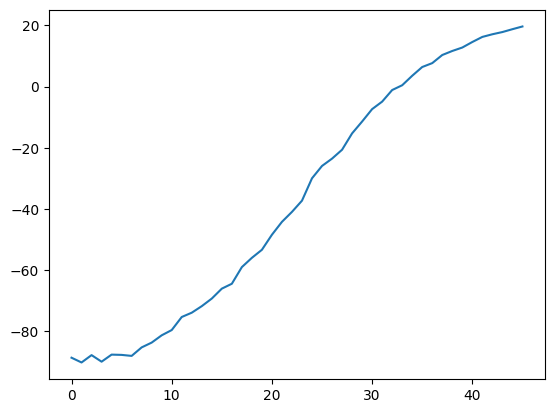

In [33]:
plt.plot(quality_list)

In [34]:
quality_list=np.array(quality_list)
np.savetxt("./experiment_new_3/alpha_variation_zero_point_zero_gain_10_k_2/quality_list_0_point_0_gain_10_k2.csv", quality_list, delimiter=",")

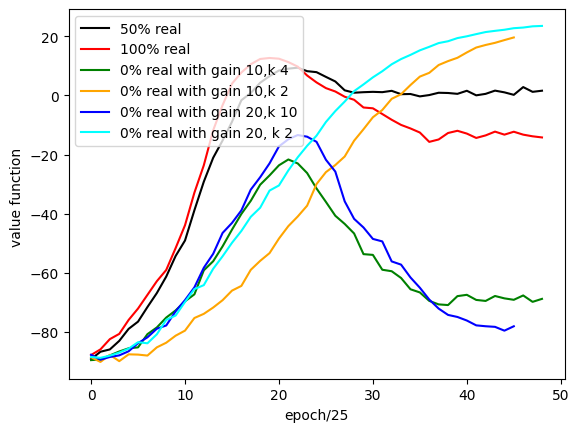

In [40]:
# from matplotlib import pyplot as plt
# Y=list(range(5))
my_data = np.genfromtxt("./experiment_new_3/alpha_variation_zero_point_five/quality_list_0_point_0_rand.csv", delimiter=',')
plt.plot(my_data,c="black",label="50% real")

my_data = np.genfromtxt("./experiment_new_3/alpha_variation_one_point_zero/quality_list_1_point_0_rand.csv", delimiter=',')
plt.plot(my_data,c="red",label="100% real")

my_data = np.genfromtxt("./experiment_new_3/alpha_variation_zero_point_zero_gain_10_k_4/quality_list_0_point_0_gain_10_k_4.csv", delimiter=',')
plt.plot(my_data,c="green",label="0% real with gain 10,k 4 ")

my_data = np.genfromtxt("./experiment_new_3/alpha_variation_zero_point_zero_gain_10_k_2/quality_list_0_point_0_gain_10_k2.csv", delimiter=',')
plt.plot(my_data,c="orange",label="0% real with gain 10,k 2 ")

my_data = np.genfromtxt("./experiment_new_3/alpha_variation_zero_point_zero_gain_20_k_10/quality_list_0_point_0_gain_20_k_2.csv", delimiter=',')
plt.plot(my_data,c="blue",label="0% real with gain 20,k 10")

my_data = np.genfromtxt("./experiment_new_3/alpha_variation_zero_point_zero_gain_20_k_2/quality_list_0_point_0_gain_20_k_2.csv", delimiter=',')
plt.plot(my_data,c="cyan",label="0% real with gain 20, k 2")

plt.xlabel("epoch/25")
plt.ylabel("value function ")
plt.legend()
plt.show()


In [270]:

# A_1.env_model.terminal_state=env.observation_space.n-1
print(A_1.env_model.state_action_to_state_dict)
# print(A_1.env_model.state_action_to_reward_dict)



{(0, 0): {0: 46.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 51.0}, (0, 1): {0: 30.0, 1: 19.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (1, 0): {0: 66.0, 1: 61.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (1, 1): {0: 1.0, 1: 44.0, 2: 58.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (2, 0): {0: 1.0, 1: 73.0, 2: 84.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (2, 1): {0: 1.0, 1: 1.0, 2: 54.0, 3: 61.0, 4: 1.0, 5: 1.0, 6: 1.0}, (3, 0): {0: 1.0, 1: 1.0, 2: 64.0, 3: 82.0, 4: 1.0, 5: 1.0, 6: 1.0}, (3, 1): {0: 1.0, 1: 1.0, 2: 1.0, 3: 63.0, 4: 73.0, 5: 1.0, 6: 1.0}, (4, 0): {0: 1.0, 1: 1.0, 2: 1.0, 3: 65.0, 4: 57.0, 5: 1.0, 6: 1.0}, (4, 1): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 49.0, 5: 53.0, 6: 1.0}, (5, 0): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 30.0, 5: 29.0, 6: 1.0}, (5, 1): {0: 1.0, 1: 24.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 18.0}, (6, 0): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (6, 1): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}}


In [841]:

def expect_num_steps(policy_param,num_of_epochs,Agent):
    
    A1=Agent
    # for param in A1.model.fc1.parameters():
    #     param.data = nn.parameter.Parameter(policy_param)
    
    horizon_len=200
    
    env.reset()
    # print(list(A_1.model.fc1.parameters()))
    
    s_t_index=env._state.index

    trajs=[]
    # D_real.flush_all()

    result=0

    b_count=[]
    rewards_sum=[]
    for traj_id in range(num_of_epochs):
        env.reset()
        # display_env()
        s_t_index=env._state.index
        
        states=[]
        log_probs=[]
        rewards=[]
        actions=[]
        nstates=[]
        
        for t in range(horizon_len):
            
            s_t=F.one_hot(torch.tensor(s_t_index),num_classes=env.observation_space.n).unsqueeze(dim=0)
            s_t=s_t.type(torch.FloatTensor)
            a_t, log_prob = A1.action(s_t)
            ns_t_index, r_t, done, _ = env.step(a_t.numpy()[0][0])
            
            states.append(s_t_index)
            actions.append(a_t)
            log_probs.append(log_prob)
            rewards.append(r_t)
            nstates.append(ns_t_index)
            s_t_index=ns_t_index
            if done:
                break
            b_count.append(len(rewards)) 
        rewards_sum.append(sum(rewards))  
        D_real.push(states, actions, rewards,nstates, log_probs)
    
    return sum(rewards_sum)/len(rewards_sum)



In [46]:
init_params=torch.Tensor([[ 0.6825,  0.8863, -1.2302, -1.1798, -1.1560, -1.0646, -1.1338, -1.0857,
         -1.0740,  1.0120, -1.1996, -1.1750, -1.2342, -0.2169, -1.2770, -1.2170,
         -1.1092, -1.1832, -1.1482, -0.8633,  1.4509, -0.9253, -0.9925, -0.7671,
          1.2539, -1.0963, -1.0425, -0.9551, -1.1699, -0.9062, -1.1976, -1.0136,
         -0.9320, -1.0067, -1.0133, -1.0154, -1.1422, -1.1834, -1.1957, -1.1596,
         -1.2002, -1.1642, -1.1950, -1.1949, -1.1934, -1.2006, -0.1996, -0.8419,
         -1.1900, -1.2040, -1.2178, -1.0663, -1.2266, -1.2790, -1.2411, -1.2221,
         -1.2150, -1.2267, -1.2698, -1.1747, -1.1789,  0.0350, -1.1914, -1.1846,
         -1.1283, -1.2682, -1.1442, -1.2541, -1.2471, -1.2594, -1.2120, -1.2714,
         -1.2630, -1.1423, -1.1326, -1.1313, -1.1311, -1.1213, -0.2080, -1.0810,
         -0.3903, -1.1010, -1.0920, -1.1611, -1.1629, -1.1649, -1.2086,  0.6375,
         -1.2256, -1.2167, -0.6320, -1.1864, -1.2075, -1.1824, -1.1949, -1.2287,
         -1.0093, -0.9339, -0.9244,  0.5000],
        [ 0.3175,  0.1137,  2.2302,  2.1798,  2.1560,  2.0646,  2.1338,  2.0858,
          2.0740, -0.0120,  2.1996,  2.1750,  2.2342,  1.2169,  2.2770,  2.2170,
          2.1092,  2.1832,  2.1482,  1.8633, -0.4509,  1.9253,  1.9925,  1.7671,
         -0.2539,  2.0963,  2.0425,  1.9551,  2.1699,  1.9062,  2.1976,  2.0136,
          1.9320,  2.0067,  2.0133,  2.0154,  2.1422,  2.1834,  2.1957,  2.1596,
          2.2002,  2.1642,  2.1950,  2.1949,  2.1934,  2.2006,  1.1996,  1.8419,
          2.1900,  2.2040,  2.2178,  2.0663,  2.2266,  2.2790,  2.2411,  2.2221,
          2.2150,  2.2267,  2.2698,  2.1747,  2.1789,  0.9650,  2.1914,  2.1846,
          2.1283,  2.2682,  2.1442,  2.2541,  2.2471,  2.2594,  2.2120,  2.2714,
          2.2630,  2.1423,  2.1326,  2.1313,  2.1311,  2.1213,  1.2080,  2.0810,
          1.3903,  2.1010,  2.0920,  2.1611,  2.1629,  2.1649,  2.2086,  0.3625,
          2.2256,  2.2167,  1.6320,  2.1863,  2.2075,  2.1824,  2.1949,  2.2287,
          2.0093,  1.9339,  1.9244,  0.5000]])
# init_params=torch.ones(env.action_space.n,env.observation_space.n)/env.action_space.n
init_para=init_params.numpy()
np.savetxt("./experiment_new/alpha_variation/dummy_exp.csv", init_para, delimiter=",")

In [18]:
my_data = np.genfromtxt("./experiment_new/alpha_variation/dummy_exp.csv", delimiter=',')
# my_data = np.genfromtxt("./experiment/init_param_big.csv", delimiter=',')
# print(my_data)

init_params=torch.from_numpy(my_data)
rew_with_good=expect_num_steps(init_params.float(),10,A_1)
print(rew_with_good)

50
19
80
2
22
62
24
6
93
64
-86.44000000000003


In [506]:
print(A_1.env_model.state_action_to_state_dict)

{(0, 0): {0: 386.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 317.0}, (0, 1): {0: 122.0, 1: 165.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (1, 0): {0: 411.0, 1: 446.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (1, 1): {0: 1.0, 1: 229.0, 2: 218.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (2, 0): {0: 1.0, 1: 206.0, 2: 212.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (2, 1): {0: 1.0, 1: 1.0, 2: 303.0, 3: 315.0, 4: 1.0, 5: 1.0, 6: 1.0}, (3, 0): {0: 1.0, 1: 1.0, 2: 217.0, 3: 181.0, 4: 1.0, 5: 1.0, 6: 1.0}, (3, 1): {0: 1.0, 1: 1.0, 2: 1.0, 3: 311.0, 4: 336.0, 5: 1.0, 6: 1.0}, (4, 0): {0: 1.0, 1: 1.0, 2: 1.0, 3: 146.0, 4: 192.0, 5: 1.0, 6: 1.0}, (4, 1): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 322.0, 5: 356.0, 6: 1.0}, (5, 0): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 90.0, 5: 102.0, 6: 1.0}, (5, 1): {0: 1.0, 1: 175.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 174.0}, (6, 0): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}, (6, 1): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}}


In [507]:
print("After")
# A_1.env_model.terminal_state=env.observation_space.n-1
print(A_1.env_model.state_action_to_reward_dict)
# print(A_1.env_model.state_action_to_reward_dict)

After
{(0, 0): {0: 0, 1: 0.0843690660432731, 2: 0.849836236335819, 3: 0.04269775042997859, 4: 0.6927689805985797, 5: 0.46587405632402956, 6: 10}, (0, 1): {0: 0, 1: 0, 2: 0.6579976854489147, 3: 0.6804551352408054, 4: 0.7221623590673689, 5: 0.3633184088247551, 6: 0.7105673467045505}, (1, 0): {0: 0, 1: 0, 2: 0.6602864723695561, 3: 0.4682956991167345, 4: 0.7539382208410857, 5: 0.8131153643545767, 6: 0.2125786449374153}, (1, 1): {0: 0.3506829104996698, 1: 0, 2: 0, 3: 0.37592047356796876, 4: 0.10817453678234279, 5: 0.709789260139768, 6: 0.30157215691137595}, (2, 0): {0: 0.9298344194564789, 1: 0, 2: 0, 3: 0.7851022144181312, 4: 0.6277917767593851, 5: 0.6000684898476814, 6: 0.3838554528756474}, (2, 1): {0: 0.9338957960775606, 1: 0.8208397716569739, 2: 0, 3: 0, 4: 0.9399701642517263, 5: 0.4573391290634353, 6: 0.03543488339963141}, (3, 0): {0: 0.3860803130577549, 1: 0.031673115214396974, 2: 0, 3: 0, 4: 0.21732761399517841, 5: 0.138098130873191, 6: 0.6636311180979971}, (3, 1): {0: 0.7300320306288

In [235]:
D_real=update_D_real(D_real,env,A_1,1)

In [156]:
A_1.env_model.update_param_given_epi(D_real)

1


In [162]:
def index_to_onehot(id):
    id=torch.tensor(id)
    s_t = torch.nn.functional.one_hot(id,num_classes=7)
    s_t=s_t.type(torch.FloatTensor)
    
    return s_t

def onehot_to_index(self,x):
    id= torch.argmax(x, dim=1)
    return id

In [271]:
A_1.MBPO_train_2(D_real,1)

0
